# ChromoPredict Tutorial
## Estimating Absorption Maxima with ChromoPredict

ChromoPredict implements established rule-based methods for estimating UV-Vis absorption maxima, including:

- **Woodward-Fieser rules** for enones (`woodward_type`)
- **Fieser rules** for conjugated dienes (`fieser`)
- **Fieser-Kuhn rules** for conjugated polyenes with at least four double bonds (`fieser_kuhn`)

By default, ChromoPredict automatically selects the appropriate rule set based on the molecular structure. For enone systems (Woodward-type), you can optionally specify which rule variant to apply, including the original scheme, Kang's extended rules<sup>[1]</sup>, or the refined rules developed in our work.

In this tutorial, we’ll walk through how to use ChromoPredict to calculate absorption maxima for various chromophores.

---

[1]  Kang G, Kang Y, Kang F-A.: The extended Woodward UV rules formula for all possible structures, [*J Phys Org Chem.* **2021**, 34, e4186](https://doi.org/10.1002/poc.4186).

In [1]:
import sys, os
import pandas as pd
import numpy as np

sys.path.append('../../Woodward_Fieser_Rules-main/src/')
import chromopredict as cp


### A) Predicting Absorption Maxima for Enone Systems Using Woodward Rule Variants

This step evaluates a series of representative enone molecules with known experimental absorption maxima.

For each compound, absorption maxima are predicted using ChromoPredict's unified `predict` function, which can automatically detect the chromophore type and rule-set but also accepts a `chromlib` parameter to specify a desired rule variant. Here we show how to get the estimations using the original (`woodward`), extended (`woodward_extended`), or refined (`woodward_refine`) Woodward rules.

Predicted values and detailed substituent contributions are collected for each rule set. Here, the results are compiled into a DataFrame to facilitate direct comparison with experimental data and between rule variants.


In [2]:
d_woodward = {
    1:  {'smiles': 'C=CC(=O)C1CCC2(CC1)OCCO2', 'nm_exp': 214},
    2:  {'smiles': 'C=C1CCCCCC1=O', 'nm_exp': 230},
    3:  {'smiles': 'C1CCC(=C2CCCCC2=O)CC1', 'nm_exp': 257},
    4:  {'smiles': 'CC(=O)C1=C(C)CCCC1', 'nm_exp': 247},
    5:  {'smiles': 'CC(C)=C1CCC(C)CC1=O', 'nm_exp': 252},
    6:  {'smiles': 'CC1=CC(=O)CC(C)(C)C1', 'nm_exp': 235},
    7:  {'smiles': 'CC=CC=CC=O', 'nm_exp': 261},
    8:  {'smiles': 'CC(=O)C=CC1=C(C)CCCC1(C)C', 'nm_exp': 283},
    9:  {'smiles': 'CC(=C1CCCCC1)C(=O)C', 'nm_exp': 242},
    10: {'smiles': 'C[C@@H]1CCC(=C(C)C)C(=O)C1', 'nm_exp': 252},
}

for idx, d_ in d_woodward.items():
    smi = d_['smiles']
    if smi != '':
        # employing original Woodward rules
        d_['nm_wf'], d_['descr_wf'], _ = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='woodward')
        
        # force Woodward extended rules to be used
        d_['nm_wfe'], d_['descr_wfe'], _ = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='woodward_extended')
        
        # use refined rules for enones, fallback is Woodward rules
        d_['nm_wfr'], d_['descr_wfr'], d_['im'] = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='woodward_refine')

df_woodward = pd.DataFrame.from_dict(d_woodward, orient='index')
df_woodward.head(n=2)

,smiles,nm_exp,nm_wf,descr_wf,nm_wfe,descr_wfe,nm_wfr,descr_wfr,im
1,C=CC(=O)C1CCC2(CC1)OCCO2,214,215,"{'base': 215, 'factor': 0, 'alpha': 'H', 'alph...",213,"{'subs': 0, 'exo': 0, 'solvent': 0}",215,"{'base': 215, 'factor': 0, 'alpha': 'H', 'alph...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,C=C1CCCCCC1=O,230,230,"{'base': 215, 'factor': 0, 'alpha': 'alkyl', '...",229,"{'subs': 1, 'exo': 1, 'solvent': 0}",231,"{'base': 215, 'factor': 0, 'alpha': 'alkyl', '...",<PIL.PngImagePlugin.PngImageFile image mode=RG...


The prediction call returns the absorption maximum estimation, as well as a verbose description of the used parameters (base values, factors and increments) if `verbose=True` as well as an image of the structure color coded by the identified Woodward structure increments, where the base structure is highlighted in light blue, substituents in blue and additional bonds in green.

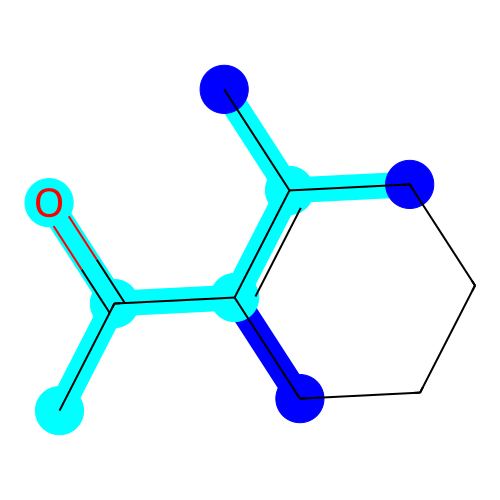

In [3]:
# Let's have a look at the image of the first example
df_woodward.loc[df_woodward['smiles'] == 'CC(=O)C1=C(C)CCCC1', 'im'].item()

In [4]:
# Let's have a look at the individual contributions to the absorption maximum for example 1
df_woodward.loc[df_woodward['smiles'] == 'CC(=O)C1=C(C)CCCC1', 'descr_wfr'].item()

{'base': 215,
 'factor': 0,
 'alpha': 'alkyl',
 'alpha_all': [{'pattern': 'alkyl', 'value': 11, 'sub_type': 'alpha'}],
 'beta': 'alkyl',
 'beta_all': [{'pattern': 'alkyl', 'value': 17, 'sub_type': 'beta'},
  {'pattern': 'alkyl', 'value': 17, 'sub_type': 'beta'}],
 'gamma': 'H',
 'gamma_all': [],
 'higher': 'H',
 'higher_all': [],
 'exo': 0,
 'solvent': 0}

As we can see, the absorption maximum of the first example compound was calculated as:

$$
\lambda_{\text{max}} = 
\underbrace{215}_{\text{base value}} + 
\underbrace{0}_{\text{exocyclic double bond}} + 
\underbrace{11}_{\alpha\text{-alkyl}} +
\underbrace{17}_{\alpha\text{-alkyl}} 
= \boxed{243~\text{nm}}
$$

For comparison, the experimental absorption maximum is $\boxed{247~\text{nm}}$.

### B) Predicting Absorption Maxima for Diene Systems Using Fieser Rules

In [5]:
d_fieser = {
    1:  {'smiles': 'CC=CC=CC', 'nm_exp': 227},
    2:  {'smiles': 'C=C1CCCC=C1', 'nm_exp': 231},
    3:  {'smiles': 'CC13CCCCC1=CC=C2CCCCC23', 'nm_exp': 282},
    4:  {'smiles': 'CC13CCC=CC1=CCC2CCCCC23', 'nm_exp': 234},
    5:  {'smiles': 'CC(=O)OC1=CCC3(C)C(=C1)C=CC2CCCCC23', 'nm_exp': 306},
    6:  {'smiles': 'C=C1CCCCC1=C', 'nm_exp': 273},
}

for idx, d_ in d_fieser.items():
    smi = d_['smiles']
    if smi != '':
        # employing the Fieser rules, with molecules being automatically detected as fieser type
        d_['nm_f'], d_['descr_f'], d_['im'] = cp.predict(smi, solvent=None, verbose=True, draw=False) #, chromlib='fieser')

df_fieser = pd.DataFrame.from_dict(d_fieser, orient='index')
df_fieser.head(n=6)

,smiles,nm_exp,nm_f,descr_f,im
1,CC=CC=CC,227,227,"{'base': 217, 'factor': 0, 'subs': {'alkyl': 1...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,C=C1CCCC=C1,231,229,"{'base': 214, 'factor': 0, 'subs': {'alkyl': 1...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,CC13CCCCC1=CC=C2CCCCC23,282,283,"{'base': 253, 'factor': 0, 'subs': {'alkyl': 2...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,CC13CCC=CC1=CCC2CCCCC23,234,234,"{'base': 214, 'factor': 0, 'subs': {'alkyl': 1...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
5,CC(=O)OC1=CCC3(C)C(=C1)C=CC2CCCCC23,306,309,"{'base': 253, 'factor': 30, 'subs': {'alkyl': ...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
6,C=C1CCCCC1=C,273,234,"{'base': 214, 'factor': 0, 'subs': {'alkyl': 1...",<PIL.PngImagePlugin.PngImageFile image mode=RG...


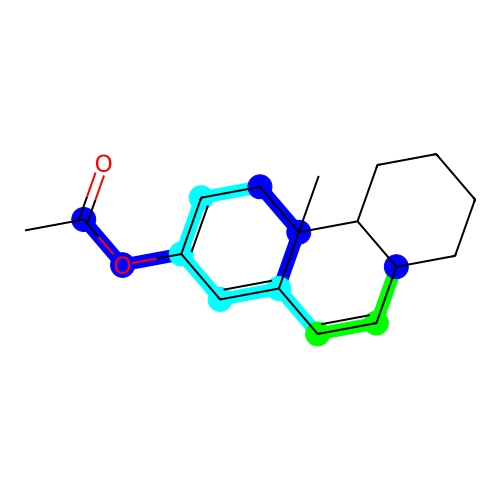

In [6]:
# Let's have a look at the image of the first example
df_fieser.loc[df_fieser['smiles'] == 'CC(=O)OC1=CCC3(C)C(=C1)C=CC2CCCCC23', 'im'].item()

In [7]:
# Let's have a look at the individual contributions to the absorption maximum for example 1
df_fieser.loc[df_fieser['smiles'] == 'CC(=O)OC1=CCC3(C)C(=C1)C=CC2CCCCC23', 'descr_f'].item()

{'base': 253, 'factor': 30, 'subs': {'alkyl': 15, 'alkoxy': 6}, 'exo': 5}

As we can see, the absorption maximum of this Fieser example is calculated on the basis of a homoannular diene (light blue highlighted) and calculated as:

$$
\lambda_{\text{max}} = 
\underbrace{253}_{\text{base value}} + 
\underbrace{5}_{\text{exocyclic double bond}} + 
\underbrace{15}_{\text{alkyl-groups~}(3\times)} +
\underbrace{6}_{\text{alkoxy-group}} 
= \boxed{309~\text{nm}}
$$

For comparison, the experimental absorption maximum is $\boxed{306~\text{nm}}$.

### C) Predicting Absorption Maxima for Polyene Systems Using Fieser-Kuhn Rules

In [25]:
d_fieser_kuhn = {
    1:  {'smiles': 'CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=C(C)/C=C/C2=C(C)CCCC2(C)C)C(C)(C)CCC1', 'nm_exp': 452},
    2:  {'smiles': 'C/C=C(\C)/C=C/C=C(\C)/C=C/C1=C(CCCC1(C)C)C', 'nm_exp': 325},
    3:  {'smiles': 'CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/C=O)/C)/C', 'nm_exp': 372},
}

for idx, d_ in d_fieser_kuhn.items():
    smi = d_['smiles']
    if smi != '':
        # employing the Fieser-Kuhn rules in the predictions
        d_['nm_fk'], d_['descr_fk'], d_['im'] = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='fieser_kuhn')

d_fieser_kuhn = pd.DataFrame.from_dict(d_fieser_kuhn, orient='index')
d_fieser_kuhn.head(n=6)

/home/carom/Dokumente/01_FAU/02_Research/2025_Woodward-Fieser-Kuhn/ref_data_alpha-beta/datasets/../../Woodward_Fieser_Rules-main/src/chromopredict/calculator.py:229: UserWarning: Requested rule set 'fieser_kuhn' is incompatible with detected rule set 'woodward'. Proceeding with detected type 'woodward'.
  warnings.warn(


,smiles,nm_exp,nm_fk,descr_fk,im
1,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,452,456,"{'M': 4, 'N': 11, 'endo': 0, 'exo': 0, 'epsilo...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,C/C=C(\C)/C=C/C=C(\C)/C=C/C1=C(CCCC1(C)C)C,325,310,"{'M': 3, 'N': 5, 'endo': 1, 'exo': 0, 'epsilon...",<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/C=O)/C)/C,372,360,"{'base': 210, 'factor': 120, 'alpha': 'H', 'al...",<PIL.PngImagePlugin.PngImageFile image mode=RG...


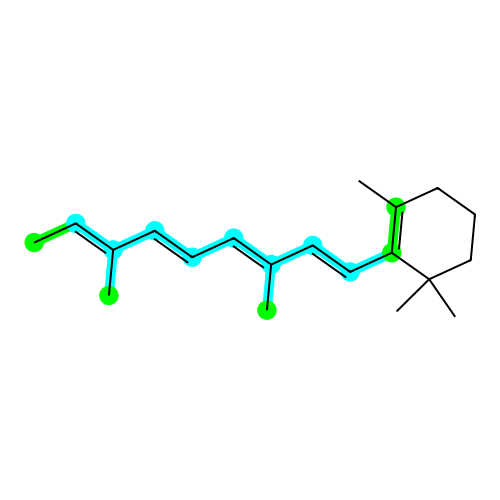

In [30]:
# Let's have a look at the image of Axerophthene
d_fieser_kuhn.loc[d_fieser_kuhn['smiles'] == 'C/C=C(\C)/C=C/C=C(\C)/C=C/C1=C(CCCC1(C)C)C', 'im'].item()

In [32]:
# Let's have a look at the individual contributions to the absorption maximum for Axerophthene
d_fieser_kuhn.loc[d_fieser_kuhn['smiles'] == 'C/C=C(\C)/C=C/C=C(\C)/C=C/C1=C(CCCC1(C)C)C', 'descr_fk'].item()

{'M': 3, 'N': 5, 'endo': 1, 'exo': 0, 'epsilon': 87000}

As we can see, the absorption maximum of this Fieser-Kuhn example is calculated as:

$$
\lambda_{\text{max}} = 
\underbrace{114}_{\text{base value}} + 
5\times\underbrace{3}_{\text{No alkyl}} + 
\underbrace{5}_{\text{No double bonds}}(48 - 1.7\times \underbrace{5}_{\text{No double bonds}}) 
= \boxed{310~\text{nm}}
$$

For comparison, the experimental absorption maximum is $\boxed{325~\text{nm}}$.